   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


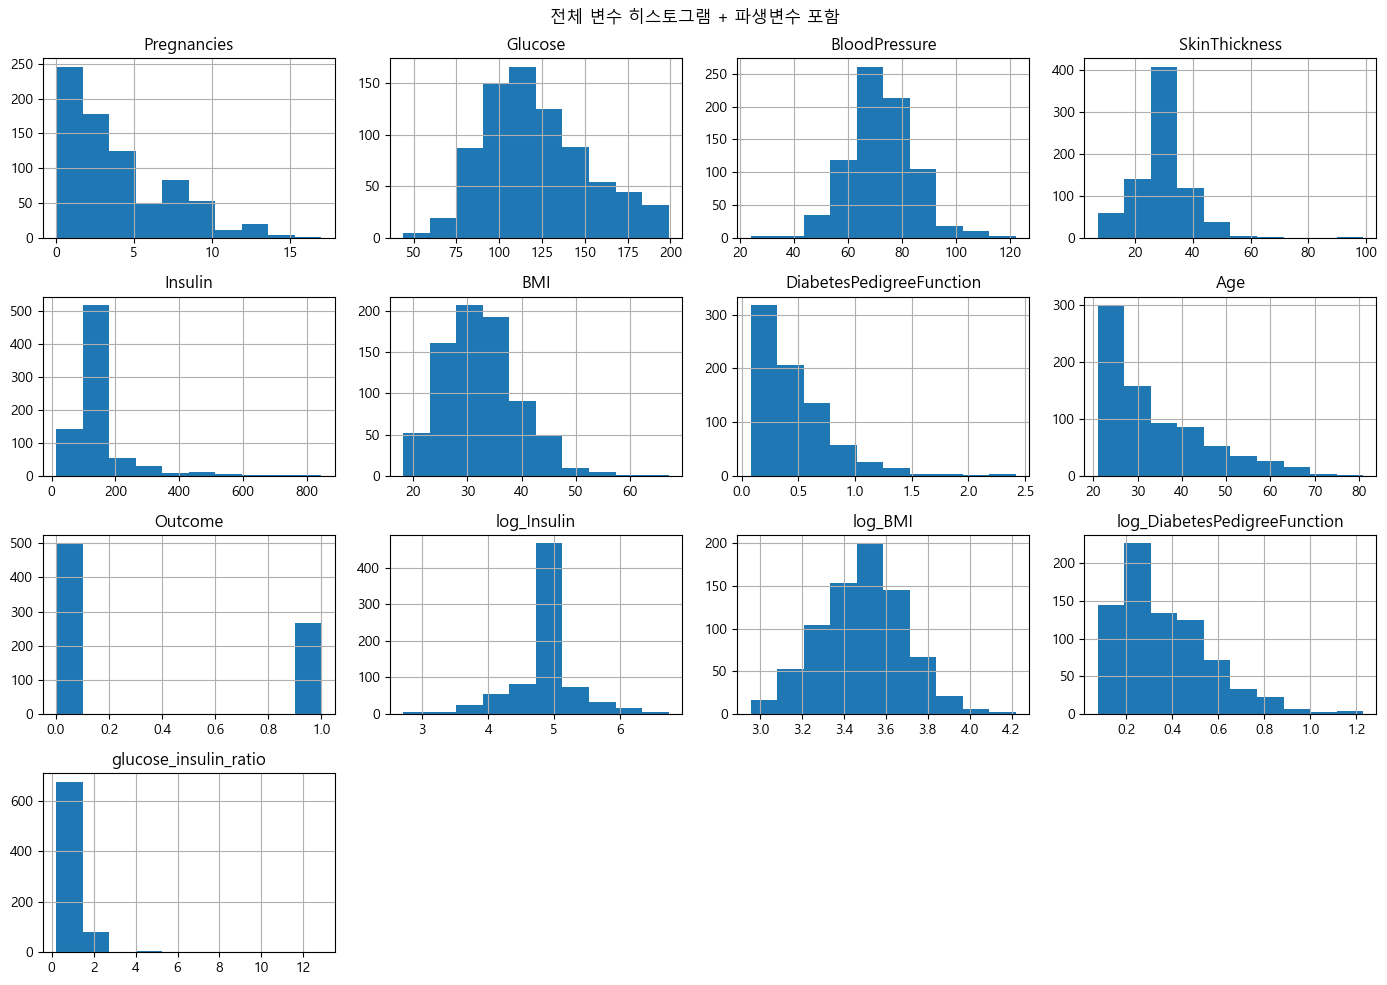

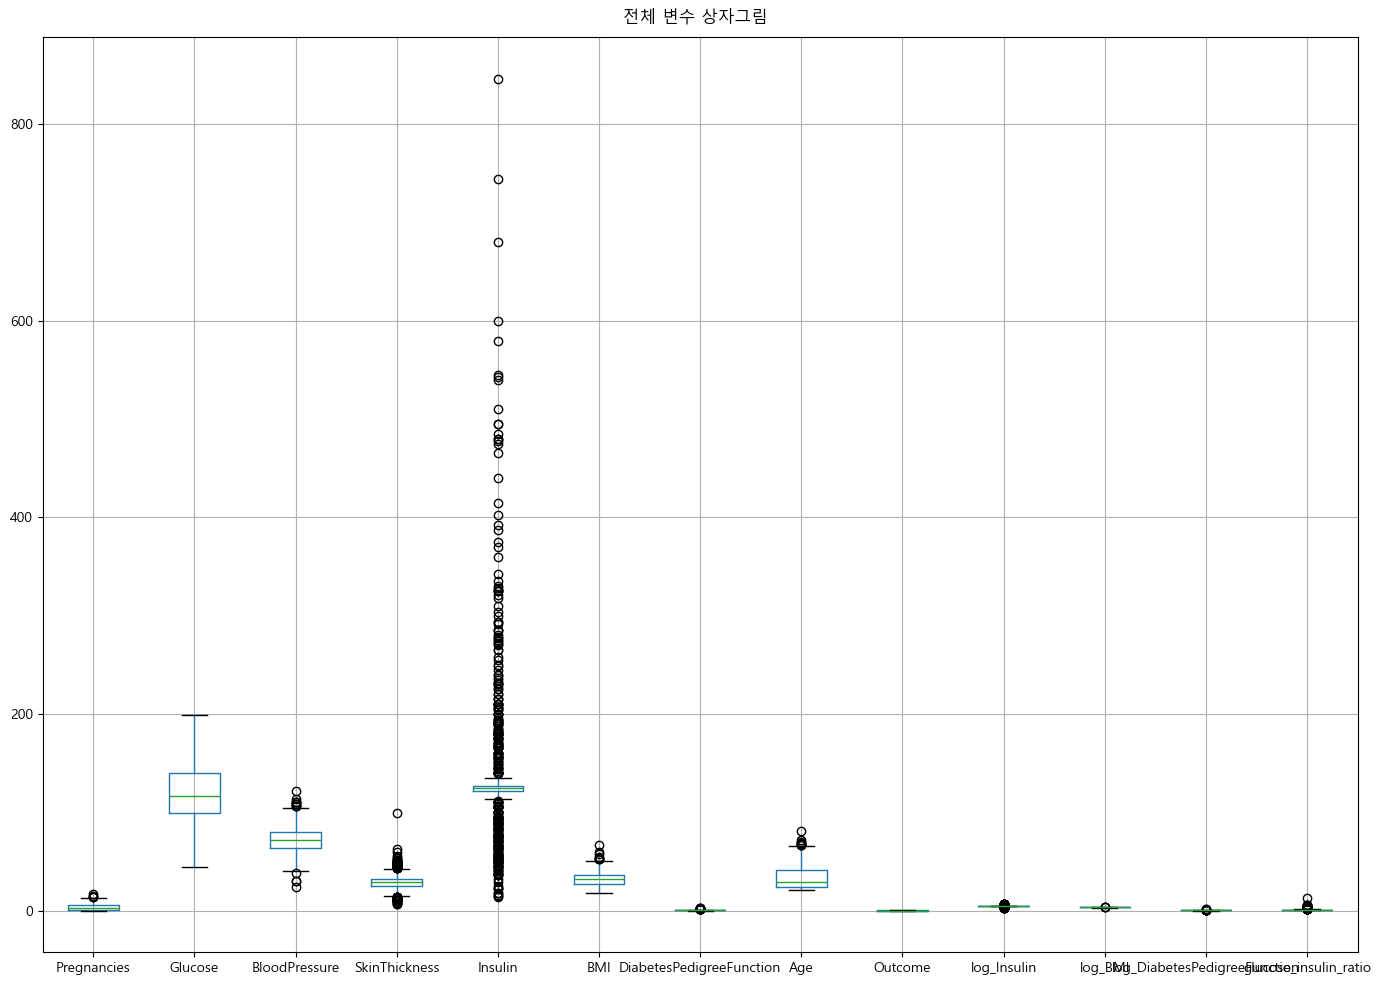

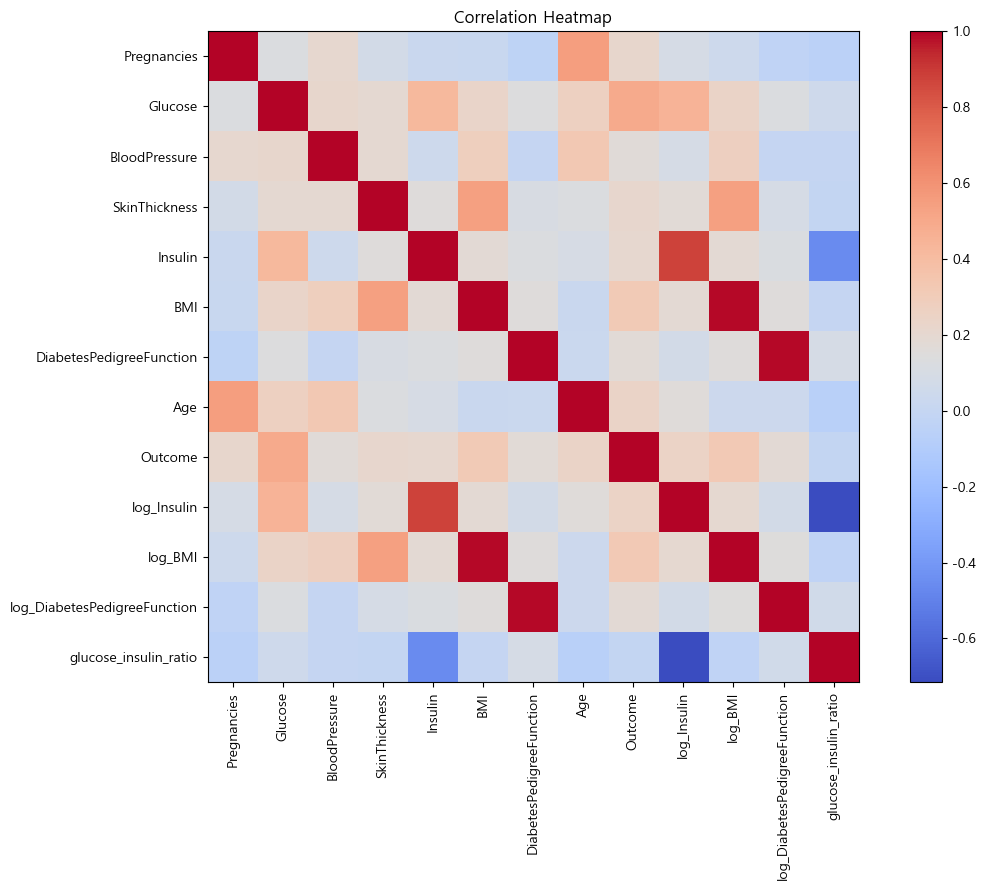


===== 선형회귀 계수 =====
절편(b0): 0.3485342019543975
계수(b1~bp):
Pregnancies: 0.06113016777267905
Glucose: 0.2106487920405124
BloodPressure: -0.004202470297949054
SkinThickness: -0.0004906479875176374
Insulin: -0.02816493073121211
BMI: 0.10978359849605655
DiabetesPedigreeFunction: -0.20184818508700503
Age: 0.017538266574875866
log_Insulin: 0.015171505811184774
log_BMI: -0.006917478531063873
log_DiabetesPedigreeFunction: 0.24221490764898684
glucose_insulin_ratio: -0.015157436209642008

===== 모델별 정확도 비교 =====
               Model  Accuracy
0         KNN (k=21)  0.766234
1  Linear Regression  0.694805
2              Ridge  0.701299
3              Lasso  0.694805


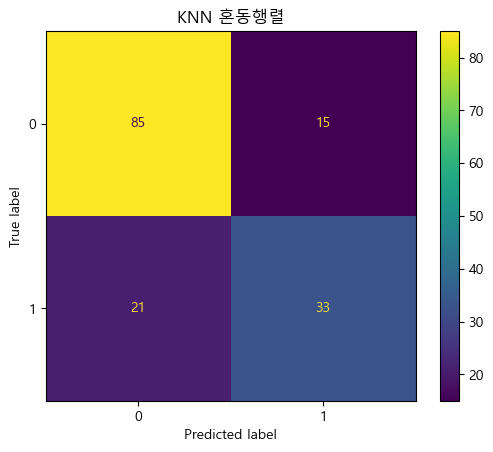

In [4]:
# 환경설정 (데이터 불러오기 + 라이브러리)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# 데이터 불러오기

diabetes = pd.read_csv("diabetes.csv", encoding="utf-8")
print(diabetes.head())


# 한글 깨짐 방지

from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False



# (0) 전처리 - 0값 처리 : 오류값
zero_na_cols = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

# 0 → NaN 변환
diabetes[zero_na_cols] = diabetes[zero_na_cols].replace(0, np.nan)

# 결측값을 중앙값으로 대체
diabetes[zero_na_cols] = diabetes[zero_na_cols].fillna(diabetes[zero_na_cols].median())


# 파생변수 생성
# (1) 로그 변환 (기울어진 분포 변수)
skew_cols = ["Insulin", "BMI", "DiabetesPedigreeFunction"]

for col in skew_cols:
    diabetes[f"log_{col}"] = np.log1p(diabetes[col])

# (2) 인슐린 대비 혈당 비율 (G/I ratio)
diabetes["glucose_insulin_ratio"] = diabetes["Glucose"] / (diabetes["Insulin"])



# (2) EDA

# 히스토그램
diabetes.hist(figsize=(14,10))
plt.suptitle("전체 변수 히스토그램 + 파생변수 포함")
plt.tight_layout()
plt.show()

# 상자그림
diabetes.boxplot(figsize=(14,10))
plt.suptitle("전체 변수 상자그림")
plt.tight_layout()
plt.show()

# 상관행렬
corr = diabetes.corr()
plt.figure(figsize=(12,9))
plt.imshow(corr, cmap="coolwarm")
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()


# 훈련/테스트 데이터
X = diabetes.drop("Outcome", axis=1) # feature
y = diabetes["Outcome"] 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)



# 스케일링
scaler = StandardScaler()
scaler.fit(X_train)

X_train_s = scaler.transform(X_train)
X_test_s  = scaler.transform(X_test)


# KNN
knn = KNeighborsClassifier(n_neighbors=21)
knn.fit(X_train_s, y_train)

knn_pred = knn.predict(X_test_s)
knn_acc = accuracy_score(y_test, knn_pred)


# Linear Regression
lr = LinearRegression()
lr.fit(X_train_s, y_train)

lr_pred = (lr.predict(X_test_s) >= 0.5).astype(int)
lr_acc = accuracy_score(y_test, lr_pred)

print("\n===== 선형회귀 계수 =====")
print("절편(b0):", lr.intercept_)
print("계수(b1~bp):")
for col, coef in zip(X.columns, lr.coef_):
    print(f"{col}: {coef}")


# Ridge
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
ridge_pred = (ridge.predict(X_test_s) >= 0.5).astype(int)
ridge_acc = accuracy_score(y_test, ridge_pred)



# Lasso
lasso = Lasso(alpha=0.001)
lasso.fit(X_train_s, y_train)
lasso_pred = (lasso.predict(X_test_s) >= 0.5).astype(int)
lasso_acc = accuracy_score(y_test, lasso_pred)


# 성능 비교표

perf = pd.DataFrame({
    "Model": ["KNN (k=21)", "Linear Regression", "Ridge", "Lasso"],
    "Accuracy": [knn_acc, lr_acc, ridge_acc, lasso_acc]
})

print("\n===== 모델별 정확도 비교 =====")
print(perf)



# 혼동행렬
cm = confusion_matrix(y_test, knn_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("KNN 혼동행렬")
plt.show()

